# 03 Running a simulation

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import ecm
import liionpack as lp
import pybamm
import numpy as np

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2022-07-15 12:05:44,798
------------------------------------------------------------
------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2022-07-15 12:05:44,833
------------------------------------------------------------
------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2022-07-15 12:05:44,841
------------------------------------------------------------


{'alpha_radial': 0.00012997486546235373, 'alpha_spiral': 0.0018925822276459076, 'lump_rho': 2499.316300105252, 'lump_Cp': 8247.24639489116}


------------------------------------------------------------
SOURCE     : liionpack.logger.get_initial_stoichiometries 
TIME STAMP : 2022-07-15 12:05:48,543
------------------------------------------------------------
Initialising simulation: 100%|███████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.45s/it]
------------------------------------------------------------
SOURCE     : liionpack.logger.get_initial_stoichiometries 
TIME STAMP : 2022-07-15 12:06:18,870
------------------------------------------------------------
Stepping simulation: 100%|███████████████████████████████████████████████████████████| 361/361 [36:15<00:00,  6.03s/it]


******************************
ECM Sim time 2208.5864493846893
******************************


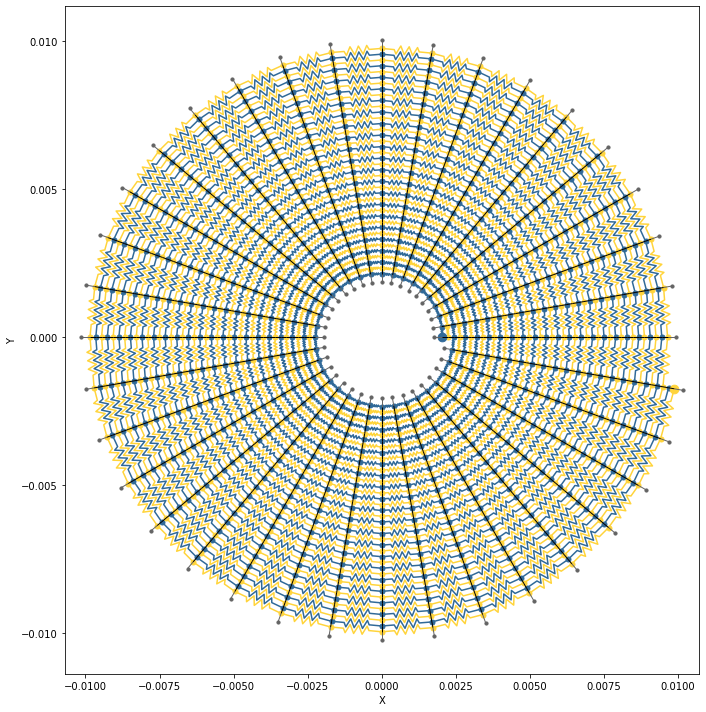

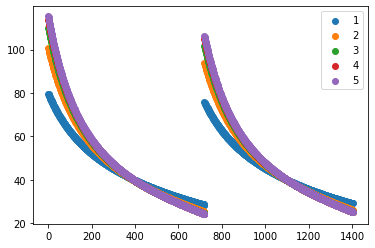

In [2]:
# pybamm.set_logging_level("INFO")
wrk = op.Workspace()
wrk.clear()

# Geometry of spiral
Nlayers = 20
dtheta = 10
spacing = 195e-6  # To do should come from params
inner_r = 10 * spacing
pos_tabs = [-1]
neg_tabs = [0]
length_3d = 0.08
tesla_tabs = False

# Experiment
I_app = 4.0
dt = 5
Nsteps = 360
hours = dt * Nsteps / 3600
experiment = pybamm.Experiment(
    [
        f"Discharge at {I_app} A for {hours} hours",
    ],
    period=f"{dt} seconds",
)

# OpenPNM project
project, arc_edges = ecm.make_spiral_net(Nlayers,
                                         dtheta,
                                         spacing,
                                         inner_r,
                                         pos_tabs,
                                         neg_tabs,
                                         length_3d,
                                         tesla_tabs)
ecm.plot_topology(project.network)
# Parameter set
param = pybamm.ParameterValues("Chen2020")
# JellyBaMM discretises the spiral using the electrode height for spiral length
# This parameter set has the longer length set to the Electrode width
# We want to swap this round
param['Electrode width [m]'] = length_3d
# Passing None as initial_soc will take values from Parameter set and apply
# uniformly everywhere
initial_soc = 0.5
thermal_props = print(ecm.lump_thermal_props(param))

# Run simulation
project, output = ecm.run_simulation_lp(parameter_values=param,
                                        experiment=experiment,
                                        initial_soc=initial_soc,
                                        project=project)

In [3]:
net = project.network
net.num_pores('free_stream')

36

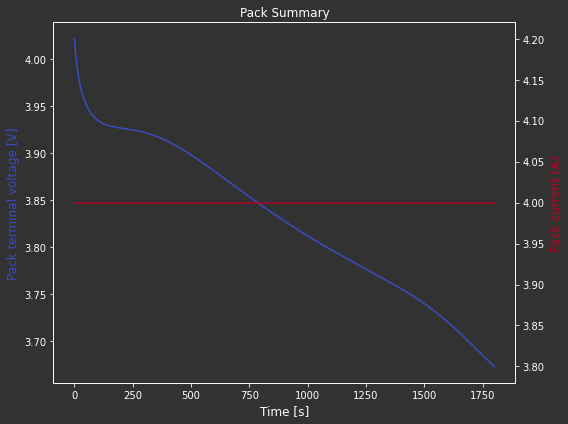

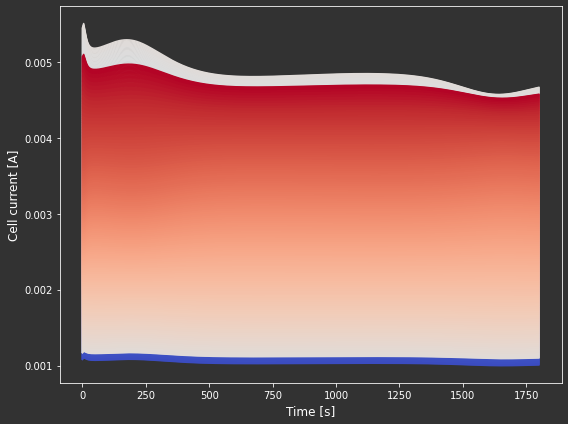

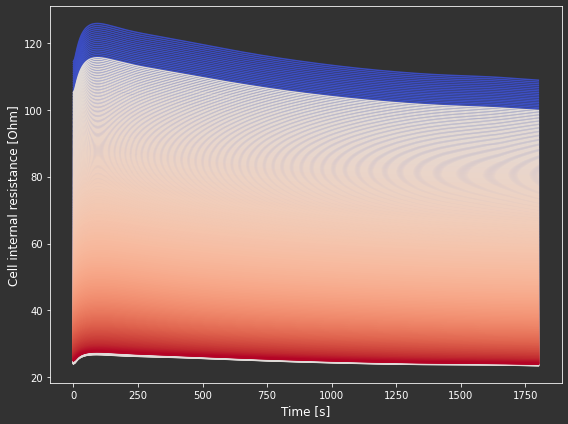

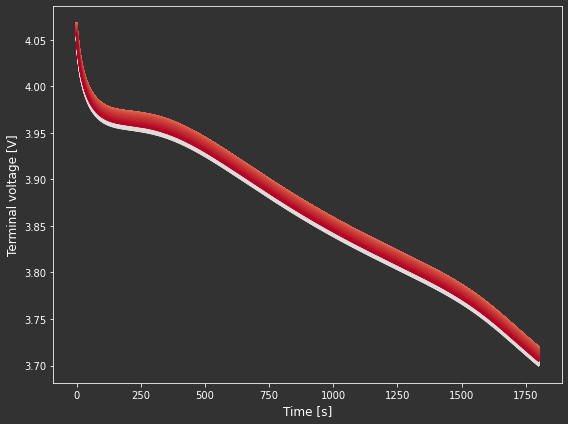

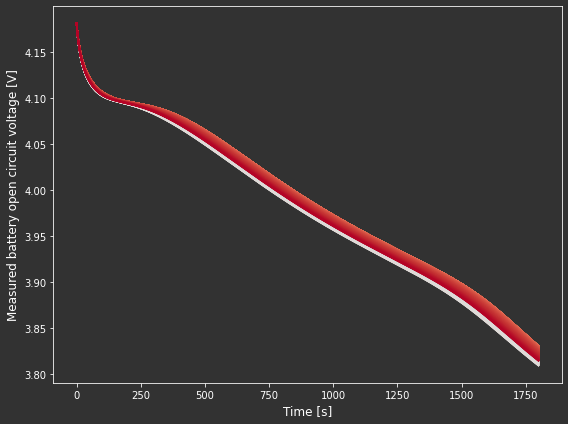

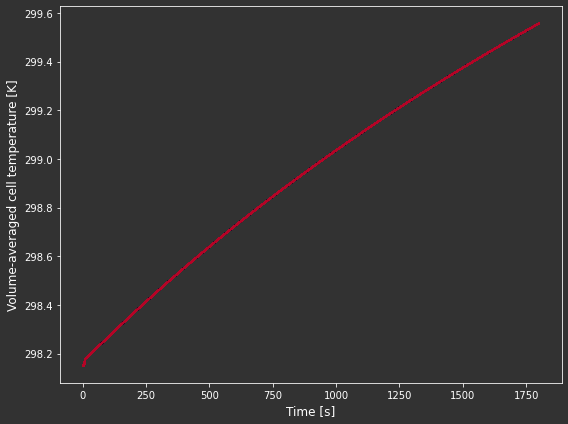

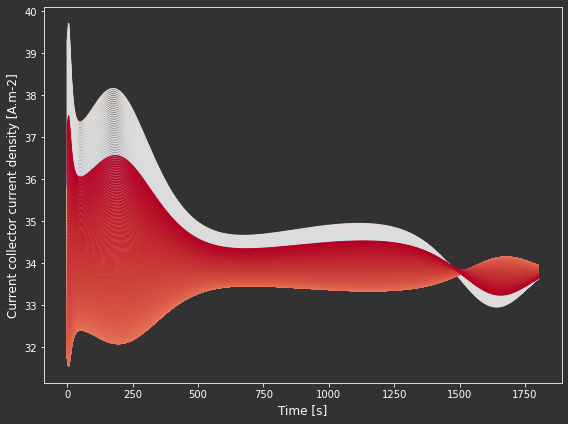

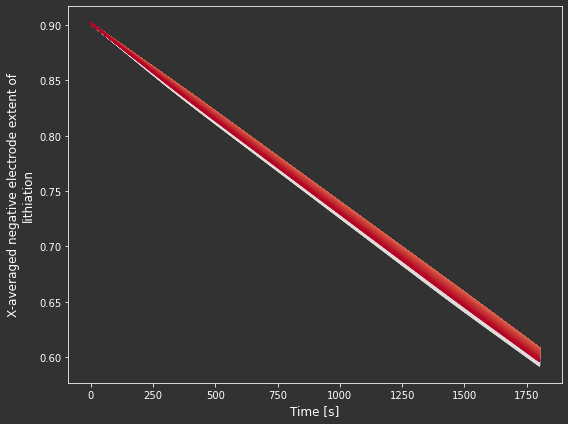

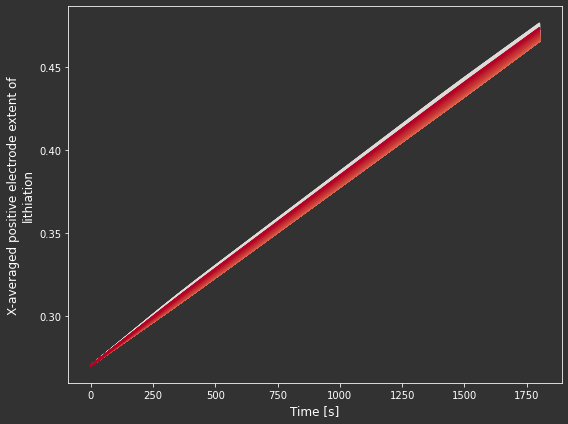

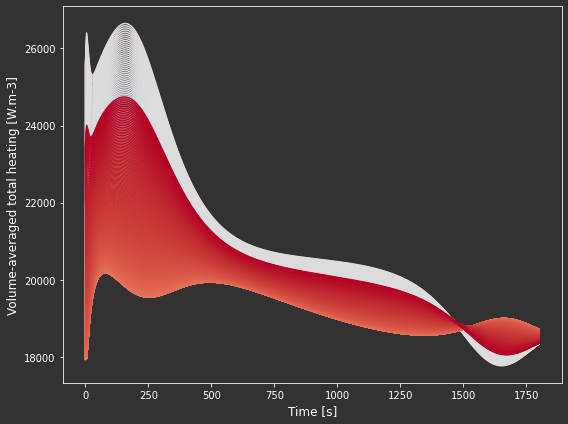

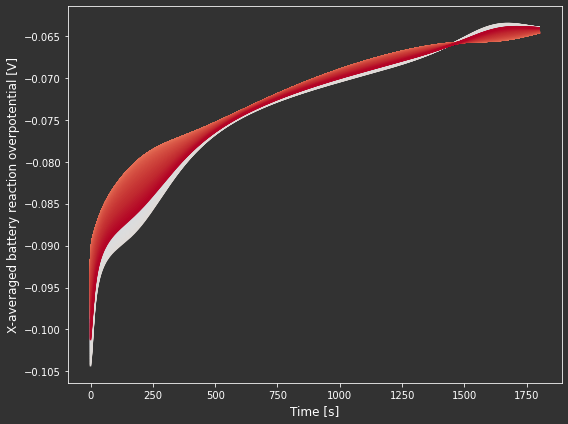

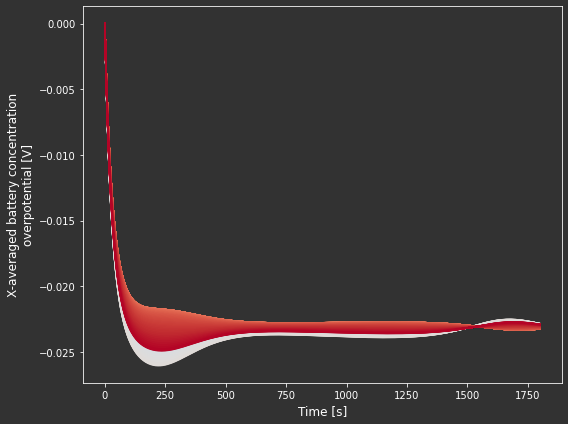

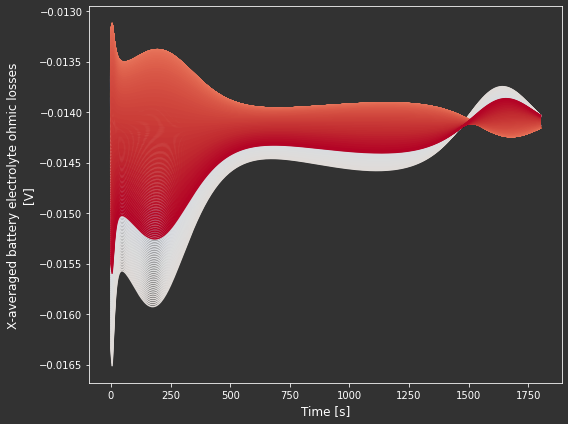

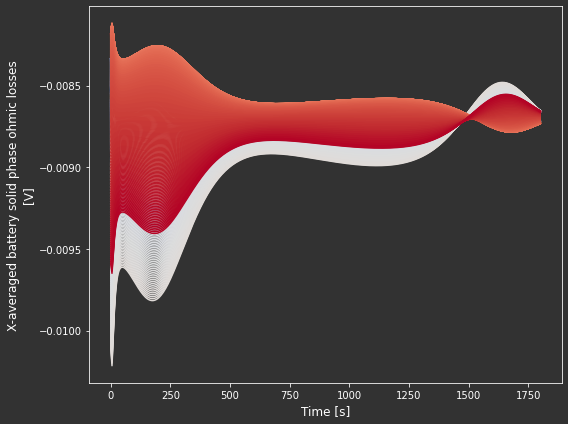

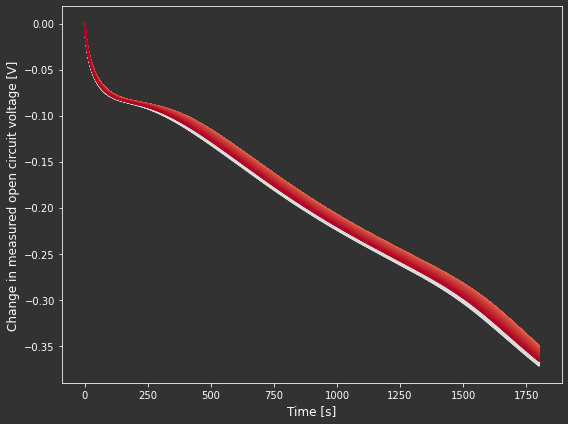

In [4]:
lp.plot_output(output)

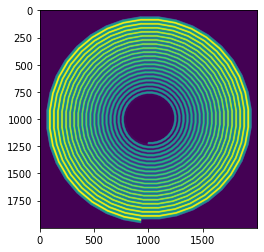

In [5]:
im_spm_map = ecm.interpolate_spm_number(project).astype(int)

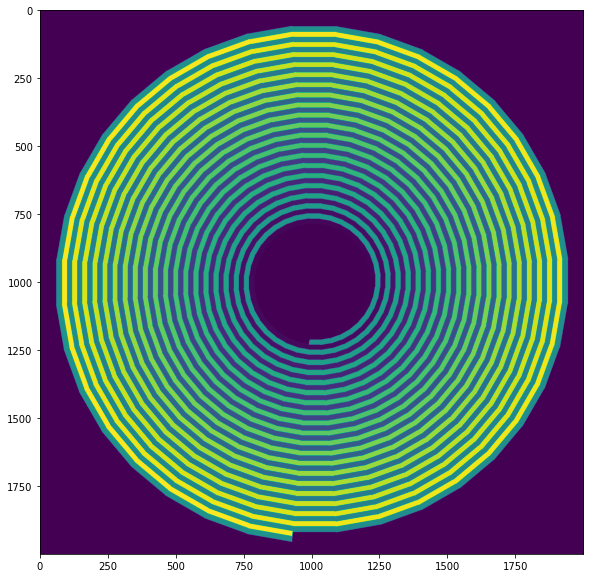

In [6]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(im_spm_map)

In [7]:
np.unique(im_spm_map)

array([  -1,    0,    1, ..., 1401, 1402, 1403])

In [8]:
mask = im_spm_map == -1

In [9]:
output.keys()

dict_keys(['Time [s]', 'Pack current [A]', 'Pack terminal voltage [V]', 'Cell current [A]', 'Cell internal resistance [Ohm]', 'Terminal voltage [V]', 'Measured battery open circuit voltage [V]', 'Volume-averaged cell temperature [K]', 'Current collector current density [A.m-2]', 'X-averaged negative electrode extent of lithiation', 'X-averaged positive electrode extent of lithiation', 'Volume-averaged total heating [W.m-3]', 'X-averaged battery reaction overpotential [V]', 'X-averaged battery concentration overpotential [V]', 'X-averaged battery electrolyte ohmic losses [V]', 'X-averaged battery solid phase ohmic losses [V]', 'Change in measured open circuit voltage [V]'])

In [10]:
t_data = output['Volume-averaged cell temperature [K]'][-1, :]
i_data = output['Current collector current density [A.m-2]'][-1, :]

In [11]:
arr = np.ones_like(im_spm_map).astype(float)

In [17]:
arr[~mask] = t_data[im_spm_map][~mask]
arr[mask] = np.nan

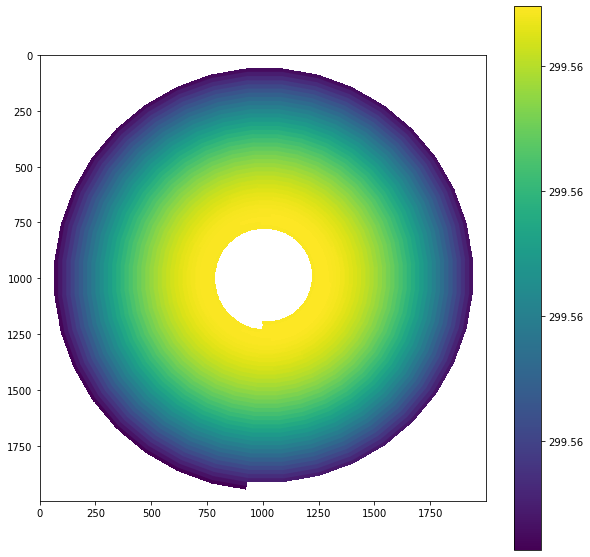

In [22]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
im = ax1.imshow(arr)
cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
cbar.ax.locator_params(nbins=6)

In [14]:
t_data.max() - t_data.min()


2.1744710807070078e-05